In [1]:
%cd ..

f:\DS Lab\OT\ot-kpgg-fc


In [2]:
import numpy as np
import os
import ot
import torch
from sklearn.cluster import KMeans
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

from optimal_transport.models import KeypointFOT

import matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pl
import ot.plot
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

c:\Users\ngtdu\AppData\Local\Programs\Python\Python39\lib\site-packages\ot\backend.py:2998: UserWarning: To use TensorflowBackend, you need to activate the tensorflow numpy API. You can activate it by running: 
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()
  register_backend(TensorflowBackend())


In [3]:
def get_data(num=20):
    np.random.seed(3)
    source = []
    target = []
    centers = [np.array([[-1,-1]]),np.array([[-3,2]]),np.array([[-2,3]]),
               np.array([[0,1]]),np.array([[-0.5,0.5]]),np.array([[-1,2]])]
    for i in range(3):
        source.append(np.random.multivariate_normal(np.array([0,0]),cov=0.05*np.array([[1,0],[0,1]]),size=num)+centers[i])
        target.append(
            np.random.multivariate_normal(np.array([0, 0]), cov=0.05 * np.array([[1, 0], [0, 1]]), size=num) + centers[
                i+3])
    return source,target

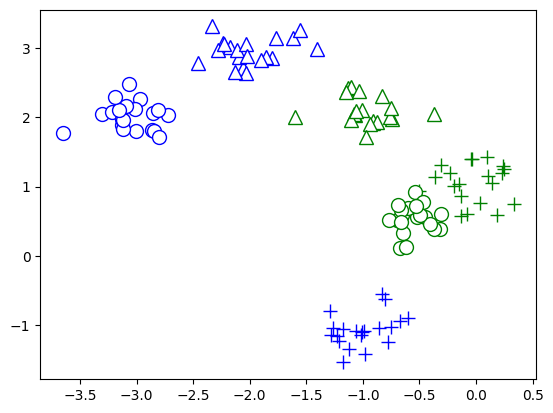

In [4]:
num = 20
source_,target_ = get_data(num)
s = ["+","o","^"]
# plot data
for i in range(3):
    plt.plot(source_[i][:,0], source_[i][:,1], 'b{}'.format(s[i]), markersize=10, markerfacecolor="white")
    plt.plot(target_[i][:,0], target_[i][:,1], 'g{}'.format(s[i]), markersize=10, markerfacecolor="white")

In [5]:
source = np.vstack(source_)
# print(source)
target = np.vstack(target_)

# plt.xticks([])
# plt.yticks([])
# plt.tight_layout()

n_anchors = 3
p = np.ones(len(source))/len(source)
q = np.ones(len(target))/len(target)

I = [3, 2*num+6, num+1]
J = [8, 2*num+13, num+1]
K = list(zip(I, J))

model = KeypointFOT(n_free_anchors=4*n_anchors, alpha=0.5, stop_thr=1e-5,
                               sinkhorn_reg=0.005, temperature=0.1, div_term=1e-10, max_iters=200)

result = model.fit(source, target, p, q, K)
Px = result.Pa_
print("Px: ", Px)
Py = result.Pb_
print("Py: ", Py)
P = Px.dot(Py)
print("P: ", P)

print(result.z_)
# Px = Px.detach().numpy()
# Py = Py.detach().numpy()

# ot.plot.plot2D_samples_mat(source, M, Px, c="grey", alpha=0.5)
# ot.plot.plot2D_samples_mat(M, target, Py, c="grey", alpha=0.5)

# s = ["+","o","^","o","+","^"]
# for i in range(3):
#     plt.plot(source_[i][:,0], source_[i][:,1], 'b{}'.format(s[i]), markersize=10, markerfacecolor="white")
#     plt.plot(target_[i][:,0], target_[i][:,1], 'g{}'.format(s[i]), markersize=10, markerfacecolor="white")
# # plot anchors
# for i in range(n_anchors):
#     if i not in K:
#         plt.plot(M[i][0], M[i][1],'r*', markersize=10+i, markerfacecolor="white")
# # plot keypoints
# t = 3
# for i in range(len(I)):
#     plt.plot(np.vstack(source)[I[i]][0], np.vstack(source)[I[i]][1],'r{}'.format(s[i]), markersize=10+t, markerfacecolor="white")
#     plt.plot(np.vstack(target)[J[i]][0], np.vstack(target)[J[i]][1],'r{}'.format(s[i]), markersize=10+t, markerfacecolor="white")
#     plt.plot(np.vstack(M)[K[i]][0], np.vstack(M)[K[i]][1],'r{}'.format(s[i]), markersize=10+t, markerfacecolor="white")

# if not os.path.exists("figure"):
#     os.makedirs("figure")
# pl.title('Factored OT with template samples')

labels = [0]*num + [1]*num + [2]*num
labels = np.array(labels)
pred = np.argmax(P,axis=1)
pred = labels[pred]
acc = np.mean(labels==pred)
print("Matching accuracy:{:.1f}%".format(acc*100))

# plt.text(-3.8,-0.5,"Matching\naccuracy: {:.1f}%".format(acc*100),fontsize=22)
# plt.savefig("figure/KP.pdf")
# plt.show()


c:\Users\ngtdu\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\ngtdu\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\ngtdu\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\ngtdu\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\cluster\

inital z:  [[-1.00484388 -1.07425577]
 [-2.0044079   2.95606348]
 [-3.05323318  2.01808847]
 [-3.05323318  2.01808847]
 [-1.00484388 -1.07425577]
 [-2.0044079   2.95606348]
 [-3.05323318  2.01808847]
 [-1.00484388 -1.07425577]
 [-2.0044079   2.95606348]
 [-3.05323318  2.01808847]
 [-1.00484388 -1.07425577]
 [-2.0044079   2.95606348]
 [-1.00484388 -1.07425577]
 [-2.0044079   2.95606348]
 [-3.05323318  2.01808847]]
Threshold reached at iteration 4
Px:  [[0.00000000e+00 0.00000000e+00 0.00000000e+00 1.58011376e-76
  3.50877193e-03 1.69428705e-87 1.58011376e-76 3.50877193e-03
  1.69428705e-87 1.58011376e-76 3.50877193e-03 1.69428705e-87
  3.50877193e-03 1.69428705e-87 1.58011376e-76]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 4.02678262e-81
  3.50877193e-03 1.80943083e-92 4.02678262e-81 3.50877193e-03
  1.80943083e-92 4.02678262e-81 3.50877193e-03 1.80943083e-92
  3.50877193e-03 1.80943083e-92 4.02678262e-81]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 2.06002317e-76
  3.50877193e-0